### **Insall nessaray libraries and packages**

In [ ]:
!pip install utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline
import pandas as pd

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
from PIL import Image, ImageFilter

In [ ]:
from keras.utils import to_categorical
from sklearn.utils import shuffle

**Load the dataset**

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/FER_2013/train/'
TEST_DIR = '/content/drive/MyDrive/FER_2013/test/'

**Read Images from the data path**

In [ ]:
import cv2

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/FER_2013/train/'
data_dir_sequence = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

img_data_list = []
emotion_counts_tr = {}

for dataset in data_dir_sequence:
    img_list = os.listdir(os.path.join(TRAIN_DIR, dataset))
    count = len(img_list)
    emotion_counts_tr[dataset] = count
    print('Loaded {} images for the dataset-{}\n'.format(count, dataset))
    for img in img_list:
        input_img = cv2.imread(os.path.join(TRAIN_DIR, dataset, img))
        if input_img is not None:
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) #it converts the image to grayscale
            input_img = cv2.equalizeHist(input_img)
            img_data_list.append(input_img)
        else:
            print(f"Failed to read image: {img}")

img_data_train = np.array(img_data_list)
img_data_train = img_data_train.astype('float32')
img_data_train = img_data_train / 255

# img_data_train = img_data_train.reshape(-1, 48, 48)  # Reshape the array to (total_count, 48, 48)

print("Emotion Counts:")
for emotion, count in emotion_counts_tr.items():
    print("{}: {}".format(emotion, count))


Loaded 3995 images for the dataset-angry

Loaded 436 images for the dataset-disgust

Loaded 4097 images for the dataset-fear

Loaded 4872 images for the dataset-happy

Loaded 4930 images for the dataset-neutral

Loaded 4830 images for the dataset-sad

Emotion Counts:
angry: 3995
disgust: 436
fear: 4097
happy: 4872
neutral: 4930
sad: 4830


In [ ]:
img_data_train.shape

(23160, 48, 48)

In [ ]:
TEST_DIR = '/content/drive/MyDrive/FER_2013/test/'
data_dir_sequence = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


img_data_list = []

emotion_counts_ts = {}

for dataset in data_dir_sequence:
    img_list = os.listdir(os.path.join(TEST_DIR, dataset))
    count = len(img_list)
    emotion_counts_ts[dataset] = count
    print('Loaded {} images for the dataset-{}\n'.format(count, dataset))
    for img in img_list:
        input_img = cv2.imread(os.path.join(TEST_DIR, dataset, img))
        if input_img is not None:
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) #it converts the image to grayscale
            input_img = cv2.equalizeHist(input_img)  # Apply histogram equalization
            img_data_list.append(input_img)
        else:
            print(f"Failed to read image: {img}")

img_data_test = np.array(img_data_list)
img_data_test = img_data_test.astype('float32')
img_data_test = img_data_test / 255

# img_data_test = img_data_test.reshape(-1, 48, 48)  # Reshape the array to (total_count, 48, 48)

print("Emotion Counts:")
for emotion, count in emotion_counts_ts.items():
    print("{}: {}".format(emotion, count))


Loaded 958 images for the dataset-angry

Loaded 111 images for the dataset-disgust

Loaded 1024 images for the dataset-fear

Loaded 1774 images for the dataset-happy

Loaded 1233 images for the dataset-neutral

Loaded 1247 images for the dataset-sad

Emotion Counts:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247


In [ ]:

img_data_test.shape

(6347, 48, 48)

**Define the number of classes**

In [ ]:
num_classes = 6
num_of_samples_train = img_data_train.shape[0]
labels_tr = np.ones((num_of_samples_train,),dtype='int64')

labels_tr[0:3995] = 5  #3995 # Angry
labels_tr[3995:4431] = 4  #436 #disgust
labels_tr[4431:8528] = 3   #4097 #fear
labels_tr[8528:13400] = 0  #4872 #happy
labels_tr[13400:18330] = 2 #4930 neutral
labels_tr[18330:] = 1 #4830 #sad
#labels_tr[18230:] = 2  #3171 #suprise

names = ['HAPPY', 'SAD', 'NEUTRAL', 'FEAR', 'DISGUST', 'ANGRY']

def getLabel(id):
    return ['HAPPY','SAD','NEUTRAL','FEAR','DISGUST','ANGRY'][id]

In [ ]:
label_counts_tr = np.bincount(labels_tr)

# Print the count of each label
for i, count in enumerate(label_counts_tr):
    label_name = getLabel(i)
    print("{}: {}".format(label_name, count))

HAPPY: 4872
SAD: 4830
NEUTRAL: 4930
FEAR: 4097
DISGUST: 436
ANGRY: 3995


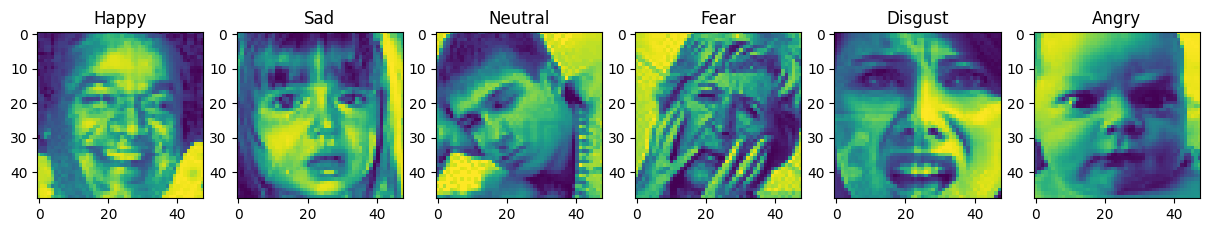

In [ ]:
import matplotlib.pyplot as plt

# Get index of images representing each expression
happy_idx = np.where(labels_tr == 0)[0][0]
sad_idx = np.where(labels_tr == 1)[0][0]
neutral_idx = np.where(labels_tr == 2)[0][0]
fear_idx = np.where(labels_tr == 3)[0][0]
disgust_idx = np.where(labels_tr == 4)[0][0]
angry_idx = np.where(labels_tr == 5)[0][0]

# Plotting the images
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(img_data_train[happy_idx])
axs[0].set_title("Happy")
axs[1].imshow(img_data_train[sad_idx])
axs[1].set_title("Sad")
axs[2].imshow(img_data_train[neutral_idx])
axs[2].set_title("Neutral")
axs[3].imshow(img_data_train[fear_idx])
axs[3].set_title("Fear")
axs[4].imshow(img_data_train[disgust_idx])
axs[4].set_title("Disgust")
axs[5].imshow(img_data_train[angry_idx])
axs[5].set_title("Angry")

plt.show()


In [ ]:
label_id = 1
label_name = getLabel(label_id)
print(label_name)  # Output: sad

SAD


In [ ]:
num_classes = 6

num_of_samples_te = img_data_test.shape[0]
labels_te = np.ones((num_of_samples_te,),dtype='int64')

labels_te[0:958]=5 #958 #Angry
labels_te[958:1069]=4 #111 #disgust
labels_te[1069:2093]=3 #1024 #fear
labels_te[2093:3867]=0 #1774 #happy
labels_te[3867:5100] =2 #1233 neutral
labels_te[5100:]=1 #1247 #sad
#labels_te[5114:]=2 #831 #suprise


names = ['HAPPY', 'SAD', 'NEUTRAL', 'FEAR', 'DISGUST', 'ANGRY']

def getLabel(id):
    return ['HAPPY', 'SAD', 'NEUTRAL', 'FEAR', 'DISGUST', 'ANGRY'][id]

In [ ]:
label_counts_te = np.bincount(labels_te)

# Print the count of each label
for i, count in enumerate(label_counts_te):
    label_name = getLabel(i)
    print("{}: {}".format(label_name, count))

HAPPY: 1774
SAD: 1247
NEUTRAL: 1233
FEAR: 1024
DISGUST: 111
ANGRY: 958


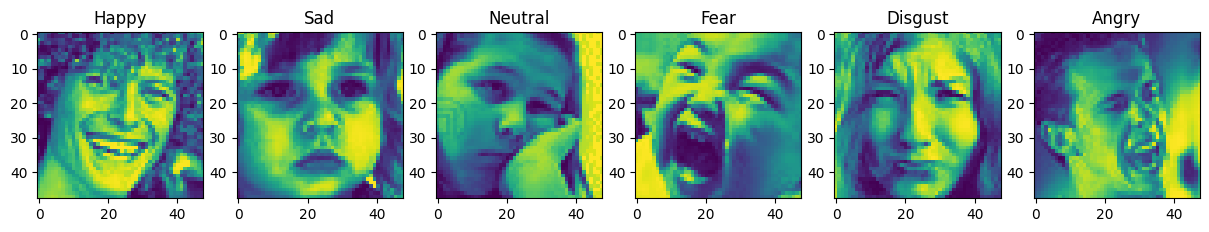

In [ ]:
import matplotlib.pyplot as plt

# Get index of images representing each expression
happy_idx = np.where(labels_te == 0)[0][0]
sad_idx = np.where(labels_te == 1)[0][0]
neutral_idx = np.where(labels_te == 2)[0][0]
fear_idx = np.where(labels_te == 3)[0][0]
disgust_idx = np.where(labels_te == 4)[0][0]
angry_idx = np.where(labels_te == 5)[0][0]

# Plotting the images
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(img_data_test[happy_idx])
axs[0].set_title("Happy")
axs[1].imshow(img_data_test[sad_idx])
axs[1].set_title("Sad")
axs[2].imshow(img_data_test[neutral_idx])
axs[2].set_title("Neutral")
axs[3].imshow(img_data_test[fear_idx])
axs[3].set_title("Fear")
axs[4].imshow(img_data_test[disgust_idx])
axs[4].set_title("Disgust")
axs[5].imshow(img_data_test[angry_idx])
axs[5].set_title("Angry")

plt.show()


**Dataset Distribution**

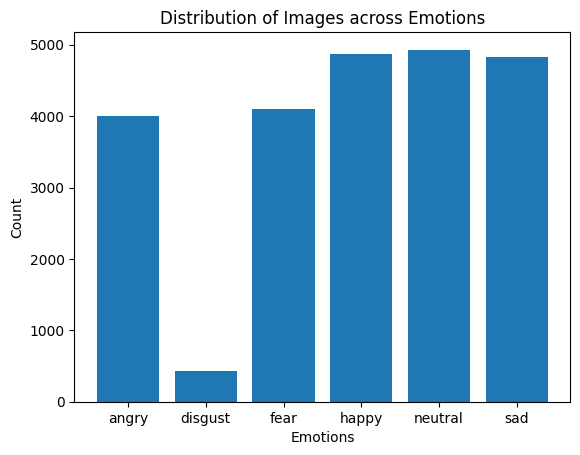

In [ ]:
emotions_tr = list(emotion_counts_tr.keys())
counts_tr = list(emotion_counts_tr.values())

# Create a bar chart
plt.bar(emotions_tr, counts_tr)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Images across Emotions')
plt.show()

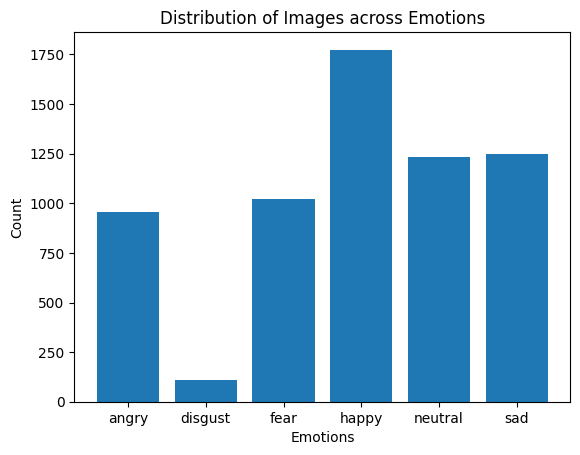

In [ ]:
emotions_ts = list(emotion_counts_ts.keys())
counts_ts = list(emotion_counts_ts.values())

# Create a bar chart
plt.bar(emotions_ts, counts_ts)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Images across Emotions')
plt.show()

**Convert the class label to one-hot encoding**

In [ ]:
#convert class labels to on-hot encoding# conve
Y_tr = to_categorical(labels_tr, num_classes)

In [ ]:
class_index1 = 3800
class_index2 = 4000
class_index3 = 5000
class_index4 = 10000
class_index5 = 18233

one_hot_label1 = Y_tr[class_index1]
one_hot_label2 = Y_tr[class_index2]
one_hot_label3 = Y_tr[class_index3]
one_hot_label4 = Y_tr[class_index4]
one_hot_label5 = Y_tr[class_index5]

print("Previous label:", labels_tr[class_index1])
print("One-hot encoded label:", one_hot_label1)

print("Previous label:", labels_tr[class_index2])
print("One-hot encoded label:", one_hot_label2)

print("Previous label:", labels_tr[class_index3])
print("One-hot encoded label:", one_hot_label3)

print("Previous label:", labels_tr[class_index4])
print("One-hot encoded label:", one_hot_label4)

print("Previous label:", labels_tr[class_index5])
print("One-hot encoded label:", one_hot_label5)


Previous label: 5
One-hot encoded label: [0. 0. 0. 0. 0. 1.]
Previous label: 4
One-hot encoded label: [0. 0. 0. 0. 1. 0.]
Previous label: 3
One-hot encoded label: [0. 0. 0. 1. 0. 0.]
Previous label: 0
One-hot encoded label: [1. 0. 0. 0. 0. 0.]
Previous label: 2
One-hot encoded label: [0. 0. 1. 0. 0. 0.]


In [ ]:
#Shuffle the dataset
x_train,y_train = shuffle(img_data_train,Y_tr, random_state=2)

In [ ]:
X_train = x_train
Y_train = y_train

In [ ]:
# convert class labels to on-hot encoding# conve
Y_te = to_categorical(labels_te, num_classes)

In [ ]:
class_index1 = 900
class_index2 = 1000
class_index3 = 2000
class_index4 = 3000
class_index5 = 5200

one_hot_label = Y_te[class_index1]
one_hot_label = Y_te[class_index2]
one_hot_label = Y_te[class_index3]
one_hot_label = Y_te[class_index4]
one_hot_label = Y_te[class_index5]

print("Previous label:", labels_tr[class_index1])
print("One-hot encoded label:", one_hot_label1)

print("Previous label:", labels_tr[class_index2])
print("One-hot encoded label:", one_hot_label2)

print("Previous label:", labels_tr[class_index3])
print("One-hot encoded label:", one_hot_label3)

print("Previous label:", labels_tr[class_index4])
print("One-hot encoded label:", one_hot_label4)

print("Previous label:", labels_tr[class_index5])
print("One-hot encoded label:", one_hot_label5)

Previous label: 5
One-hot encoded label: [0. 0. 0. 0. 0. 1.]
Previous label: 5
One-hot encoded label: [0. 0. 0. 0. 1. 0.]
Previous label: 5
One-hot encoded label: [0. 0. 0. 1. 0. 0.]
Previous label: 5
One-hot encoded label: [1. 0. 0. 0. 0. 0.]
Previous label: 3
One-hot encoded label: [0. 0. 1. 0. 0. 0.]


In [ ]:
#Shuffle the dataset
x_test,y_test = shuffle(img_data_test,Y_te, random_state=2)

In [ ]:
X_test = x_test
Y_test = y_test

In [ ]:
print(X_train.shape , X_test.shape, Y_train.shape ,Y_test.shape)

(23160, 48, 48) (6347, 48, 48) (23160, 6) (6347, 6)


# **Handling imbalncing**

In [ ]:
from sklearn.utils import class_weight

**Class weights**

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels_tr),
                                        y = labels_tr
                                    )
class_weights = dict(zip(np.unique(labels_tr), class_weights))
class_weights

{0: 0.7922824302134647,
 1: 0.7991718426501035,
 2: 0.7829614604462475,
 3: 0.9421527947278496,
 4: 8.853211009174313,
 5: 0.9662077596996246}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# X_train = np.stack((X_train,)*3, axis = -1)
# X_test = np.stack((X_test,)*3, axis = -1)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

In [ ]:
print(X_train.shape , X_test.shape, Y_train.shape ,Y_test.shape)

(23160, 48, 48, 1) (6347, 48, 48, 1) (23160, 6) (6347, 6)


**Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(rotation_range=10)

In [ ]:
# from keras.utils.data_utils import Sequence
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.tensorflow import balanced_batch_generator

# class BalancedDataGenerator(Sequence):
#     """ImageDataGenerator + RandomOversampling"""
#     def __init__(self, x, y, datagen, batch_size=32):
#         self.datagen = datagen
#         self.batch_size = min(batch_size, x.shape[0])
#         datagen.fit(x)
#         self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

#         self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])   #class imbalance by oversampling the minority classes

#     def __len__(self):
#         return self.steps_per_epoch

#     def __getitem__(self, idx):
#         x_batch, y_batch = self.gen.__next__()
#         x_batch = x_batch.reshape(-1, *self._shape[1:])
#         return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [ ]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        samplewise_std_normalization=False,  # divide each input by its std
                        zca_whitening=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=.1,
                        horizontal_flip=True,
                        vertical_flip=False)


balanced_gen = data_generator.flow(X_train, Y_train,)


In [ ]:
# Create an instance of the data generator
# balanced_gen = BalancedDataGenerator(X_train, Y_train, datagen, batch_size=32)
# balanced_gen_train = ImageDataGenerator(X_test, Y_test)

**Learning Rate Scheduler**

In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10,       #that adjusts the learning rate of a model based on changes in the loss function value.
                 decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()

        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:

            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)

            target_loss = self.history[self.loss_type]

            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):

                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:

                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)


        return tf.keras.backend.get_value(self.model.optimizer.lr)



In [ ]:
callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=5)

# **Model Buliding**

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization
from keras.regularizers import l2  # Import l2 function

In [ ]:
from tensorflow.keras.layers import concatenate
!pip install keras

In [ ]:
img_size = 48

In [ ]:
# model = Sequential()
# model.add(Conv2D(256,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),activation='relu',input_shape=(img_size,img_size,1)))
# model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu'))
# model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu'))
# model.add(BatchNormalization()) #and 'same' padding. It uses the L2 regularization with a regularization factor of 0.001.
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.4))

# model.add(Conv2D(512,kernel_size=(3,3),kernel_regularizer=l2(0.001),activation='relu'))
# model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
# model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.4))

# model.add(Conv2D(1024,kernel_size=(3,3),kernel_regularizer=l2(0.001),activation='relu'))
# model.add(Conv2D(1024,kernel_size=(3,3),activation='relu'))
# model.add(Conv2D(1024,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.4)) # dropout rate of 0.4 is included to reduce overfitting

# model.add(Flatten()) #Flatten layer is added to flatten the feature maps into a 1-dimensional vector.


# model.add(Dense(2048,kernel_regularizer=l2(0.001),activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(6,activation='softmax'))

# model.summary()

In [ ]:
# model = Sequential()
# model.add(Conv2D(64,kernel_size=(3,3),kernel_regularizer=l2(0.0001),activation='relu',input_shape=(48,48,1)))
# model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.3))

# model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer=l2(0.0001),activation='relu'))
# model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.5))

# model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=l2(0.0001),activation='relu'))
# model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.5))

# model.add(Flatten())


# model.add(Dense(1024,kernel_regularizer=l2(0.001),activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(6,activation='softmax'))

# model.summary()

In [ ]:

    num_classes = 6
    model = Sequential()
    #the 1-st block
    model.add(Conv2D(64,(3,3),padding='same',input_shape =(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256,))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512,))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes,activation='softmax'))



    print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
# # Defining the model

# input_shape=img_data[0].shape

# model = Sequential()

# # Feature Extraction
# # model.add(Convolution2D(32,3,3, border_mode='same',input_shape=input_shape))
# # model.add(Activation('relu'))
# # model.add(Convolution2D(32, 3, 3))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.5))

# # model.add(Convolution2D(64, 3, 3))
# # model.add(Activation('relu'))
# # # model.add(Convolution2D(64, 3, 3))
# # # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.5))

# # model.add(Convolution2D(128, 3, 3))
# # model.add(Activation('relu'))
# # # model.add(Convolution2D(128, 3, 3))
# # # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.5))

# #new Code
# model.add(Convolution2D(6, 5, 5, input_shape=input_shape, border_mode='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(16, 5, 5, border_mode='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(120, 5, 5))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(84))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

# # Classification
# # model.add(Flatten())
# # model.add(Dense(64))
# # model.add(Activation('relu'))
# # model.add(Dropout(0.5))
# # model.add(Dense(num_classes))
# # model.add(Activation('softmax'))

# #Compile Model
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [ ]:
from keras import optimizers
from keras.layers import GlobalMaxPool2D
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [ ]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

filepath = '/content/drive/MyDrive/Reserch/models/best_model_cifar10_generala.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)


stop = EarlyStopping(monitor='val_accuracy', patience =5,
                      verbose=0, mode='auto', baseline=None,
                      restore_best_weights=False)




callbacks = [stop,checkpoint,callback_lr ]

# **Train the model**

In [ ]:
batch = 32
epoch = 50
optimizer = Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(balanced_gen, batch_size=batch, class_weight=class_weights,epochs = epoch, validation_data=(X_test, Y_test),callbacks=callbacks)


Setting learning rate to 0.001
Epoch 1/50
723/724 [============================>.] - ETA: 0s - loss: 1.9468 - accuracy: 0.1921
Epoch 1: val_accuracy improved from -inf to 0.14590, saving model to /content/drive/MyDrive/Reserch/models/best_model_cifar10_generala.hdf5
724/724 [==============================] - 66s 56ms/step - loss: 1.9461 - accuracy: 0.1923 - val_loss: 1.8249 - val_accuracy: 0.1459
Setting learning rate to 0.001
Epoch 2/50
723/724 [============================>.] - ETA: 0s - loss: 1.7756 - accuracy: 0.2482
Epoch 2: val_accuracy improved from 0.14590 to 0.19773, saving model to /content/drive/MyDrive/Reserch/models/best_model_cifar10_generala.hdf5
724/724 [==============================] - 26s 36ms/step - loss: 1.7765 - accuracy: 0.2482 - val_loss: 1.9165 - val_accuracy: 0.1977
Setting learning rate to 0.001
Epoch 3/50
724/724 [==============================] - ETA: 0s - loss: 1.6515 - accuracy: 0.3039
Epoch 3: val_accuracy improved from 0.19773 to 0.31101, saving model t

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

199/199 [==============================] - 2s 8ms/step - loss: 1.0672 - accuracy: 0.5774


**Prediction results**

In [ ]:
from tabulate import tabulate

# Define the emotion label mapping
label_mapping = {
    0: "happy",
    1: "sad",
    2: "neutral",
    3: "fear",
    4: "disgust",
    5: "angry"
}

# Make predictions on the training data
Y_pred = model.predict(X_train)

# Select a few examples to display
num_examples = 10
indices = np.random.randint(0, len(X_train), num_examples)

# Prepare the data for the table
table_data = []
for index in indices:
    predicted_label = np.argmax(Y_pred[index])  # Get the index of the predicted class with the highest probability
    actual_label = np.argmax(Y_train[index])  # Get the index of the actual class
    predicted_emotion = label_mapping[predicted_label]
    actual_emotion = label_mapping[actual_label]
    table_data.append([index, predicted_emotion, actual_emotion])

# Display the table
table_headers = ["Example", "Predicted Label", "Actual Label"]
table = tabulate(table_data, headers=table_headers, tablefmt="fancy_grid")
print(table)


724/724 [==============================] - 4s 5ms/step
╒═══════════╤═══════════════════╤════════════════╕
│   Example │ Predicted Label   │ Actual Label   │
╞═══════════╪═══════════════════╪════════════════╡
│     14389 │ neutral           │ angry          │
├───────────┼───────────────────┼────────────────┤
│      8808 │ neutral           │ sad            │
├───────────┼───────────────────┼────────────────┤
│      2946 │ fear              │ fear           │
├───────────┼───────────────────┼────────────────┤
│     19380 │ neutral           │ fear           │
├───────────┼───────────────────┼────────────────┤
│     10987 │ neutral           │ angry          │
├───────────┼───────────────────┼────────────────┤
│      3677 │ angry             │ neutral        │
├───────────┼───────────────────┼────────────────┤
│     16208 │ neutral           │ neutral        │
├───────────┼───────────────────┼────────────────┤
│     22721 │ neutral           │ angry          │
├───────────┼──────────────

In [ ]:
def plotting_epochs(training_, validation_, lossOrAccu):
  plt.figure(figsize=[6,4])
  plt.plot(training_, 'black', linewidth=2.0)
  plt.plot(validation_, 'blue', linewidth=2.0)
  plt.legend(['Training '+lossOrAccu, 'Validation '+lossOrAccu], fontsize=14)
  plt.xlabel('Epochs', fontsize=10)
  plt.ylabel(lossOrAccu, fontsize=10)
  plt.title(lossOrAccu+' Curves', fontsize=12)

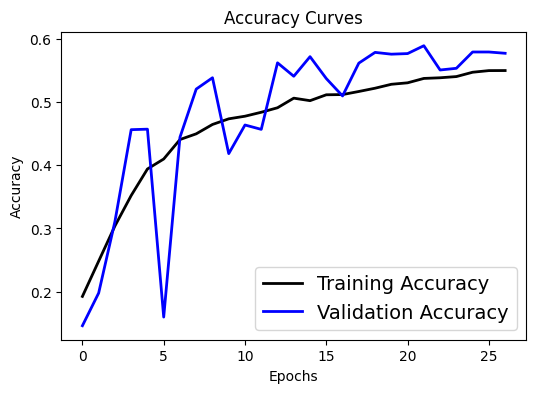

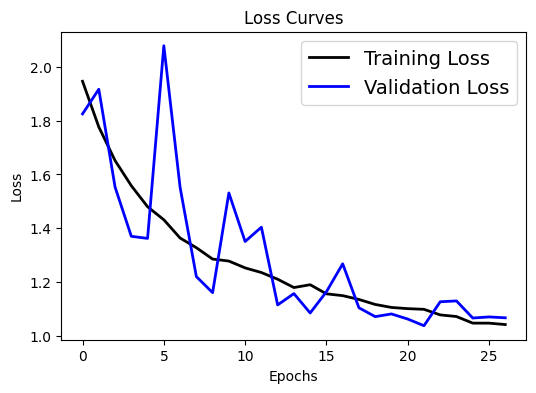

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

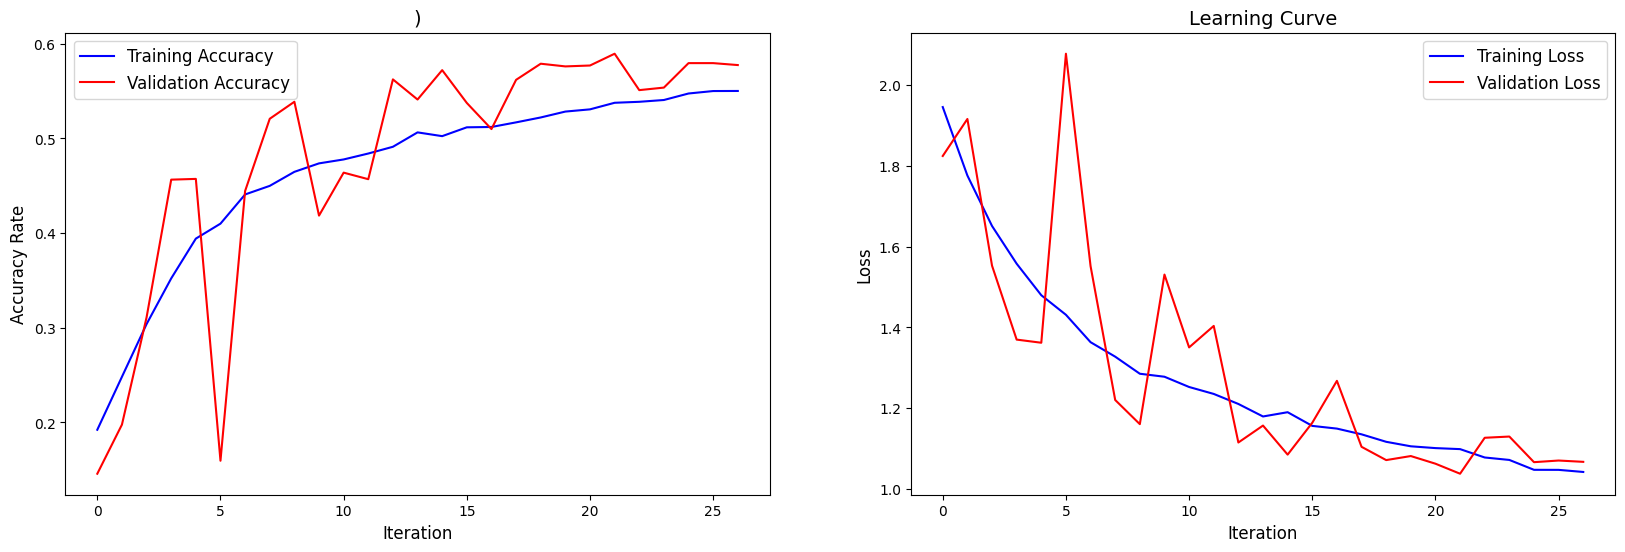

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title(')',fontsize=14)

ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

199/199 [==============================] - 1s 5ms/step


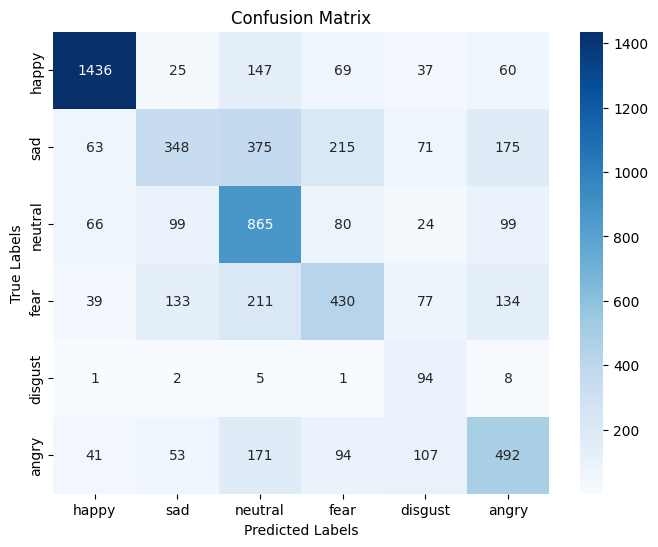

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a trained model named 'model' and test data X_test with corresponding true labels Y_test

# Make predictions on the test data
Y_pred = model.predict(X_test)

# Get the class labels with the highest probability for each prediction
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels for the test data
y_true = np.argmax(Y_test, axis=1)

# Assuming you have the true labels (y_true) and predicted labels (y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a list of class labels
class_labels = ['happy', 'sad', 'neutral', 'fear', 'disgust', 'angry']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:

from sklearn.metrics import classification_report

# Assuming you have a trained model named 'model' and test data X_test and corresponding labels Y_test

# Make predictions on the test data
Y_pred = model.predict(X_test)
predicted_labels = np.argmax(Y_pred, axis=1)

# Generate classification report
report = classification_report(np.argmax(Y_test, axis=1), predicted_labels)

print(report)


199/199 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1774
           1       0.53      0.28      0.36      1247
           2       0.49      0.70      0.58      1233
           3       0.48      0.42      0.45      1024
           4       0.23      0.85      0.36       111
           5       0.51      0.51      0.51       958

    accuracy                           0.58      6347
   macro avg       0.52      0.60      0.52      6347
weighted avg       0.60      0.58      0.57      6347



In [ ]:
# import dlib
# from PIL import Image
# from skimage import io, color
# import matplotlib.pyplot as plt

# def detect_faces(image):
#     # Create a face detector
#     face_detector = dlib.get_frontal_face_detector()

#     # Convert image to RGB if it's in a different format
#     if image.ndim == 2:
#         # Grayscale image
#         image = color.gray2rgb(image)
#     elif image.ndim == 4:
#         # RGBA image
#         image = image[..., :3]

#     # Run detector and get bounding boxes of the faces in the image
#     detected_faces = face_detector(image, 1)
#     face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]

#     return face_frames

# # Load image
# img_path = '/content/drive/MyDrive/photos/S057_001_00000019.png'
# image = io.imread(img_path)

# # Detect faces
# detected_faces = detect_faces(image)
# tab_faces = []
# # Crop faces and plot
# for n, face_rect in enumerate(detected_faces):
#     face = Image.fromarray(image).crop(face_rect)
#     tab = np.asarray(face)
#     tab_faces.append(tab)
#     plt.subplot(1, len(detected_faces), n+1)
#     plt.axis('off')
#     plt.imshow(face)

# plt.show()


In [ ]:
# image_to_predict = np.asarray(face)
# img = cv2.resize(image_to_predict,(48,48),1)

In [ ]:
# inv_dic = {
#     0: 'happy',
#     1: 'sad',
#     2: 'suprise',
#     3: 'fear',
#     4: 'disgust',
#     5: 'angry'
#     # Add more class labels and indices as needed
# }


In [ ]:
# tab = []
# tab.append(img)
# tab = np.array(tab)
# print(inv_dic[np.argmax(model.predict(tab))])
# # plt.imshow(tab[0],cmap = plt.cm.binary)

In [ ]:
# for img in tab_faces :
#   img = img = cv2.resize(img,(48,48),3)
#   tab = []
#   tab.append(img)
#   tab = np.array(tab)
#   print(inv_dic[np.argmax(model.predict(tab))])

In [ ]:
# # Load and display the original image
# original_image = Image.fromarray(image)
# plt.figure()
# plt.imshow(original_image)
# plt.axis('off')
# plt.show()

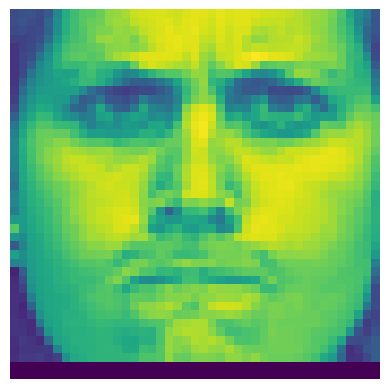

In [ ]:
import dlib
from PIL import Image
from skimage import io, color
import matplotlib.pyplot as plt

def detect_faces(image):
    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Convert image to RGB if it's in a different format
    if image.ndim == 2:
        # Grayscale image
        image = color.gray2rgb(image)
    elif image.ndim == 4:
        # RGBA image
        image = image[..., :3]

    # Run detector and get bounding boxes of the faces in the image
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]

    return face_frames

# Load image
img_path = '/content/drive/MyDrive/photos/S999_001_00000018.png'
image = io.imread(img_path)

# Detect faces
detected_faces = detect_faces(image)
tab_faces = []
# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(image).crop(face_rect)
    tab = np.asarray(face)
    tab_faces.append(tab)
    plt.subplot(1, len(detected_faces), n+1)
    plt.axis('off')
    plt.imshow(face)

plt.show()

In [ ]:
image_to_predict = np.asarray(face)
img = cv2.resize(image_to_predict,(48,48),1)

In [ ]:
inv_dic = {
    0: 'happy',
    1: 'sad',
    2: 'neutral',
    3: 'fear',
    4: 'disgust',
    5: 'angry'
    # Add more class labels and indices as needed
}


In [ ]:
tab = []
tab.append(img)
tab = np.array(tab)
print(inv_dic[np.argmax(model.predict(tab))])
# plt.imshow(tab[0],cmap = plt.cm.binary)

1/1 [==============================] - 0s 383ms/step
angry


In [ ]:
for img in tab_faces :
  img = img = cv2.resize(img,(48,48),3)
  tab = []
  tab.append(img)
  tab = np.array(tab)
  print(inv_dic[np.argmax(model.predict(tab))])

1/1 [==============================] - 0s 25ms/step
angry


In [ ]:
# # Load and display the original image
# original_image = Image.fromarray(image)
# plt.figure()
# plt.imshow(original_image)
# plt.axis('off')
# plt.show()